# Importing Libraries and Loading the Dataset


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# For modeling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from statsmodels.tsa.arima.model import ARIMA
# import statsmodels.api as sm


# Read the dataset
df = pd.read_csv('GlobalWeatherRepository.csv')

print(f"Dataset shape: {df.shape}")
print(f"First 5 rows:\n{df.head()}")



Dataset shape: (58853, 41)
First 5 rows:
       country     location_name  latitude  longitude        timezone  \
0  Afghanistan             Kabul     34.52      69.18      Asia/Kabul   
1      Albania            Tirana     41.33      19.82   Europe/Tirane   
2      Algeria           Algiers     36.76       3.05  Africa/Algiers   
3      Andorra  Andorra La Vella     42.50       1.52  Europe/Andorra   
4       Angola            Luanda     -8.84      13.23   Africa/Luanda   

   last_updated_epoch      last_updated  temperature_celsius  \
0          1715849100  2024-05-16 13:15                 26.6   
1          1715849100  2024-05-16 10:45                 19.0   
2          1715849100  2024-05-16 09:45                 23.0   
3          1715849100  2024-05-16 10:45                  6.3   
4          1715849100  2024-05-16 09:45                 26.0   

   temperature_fahrenheit condition_text  ...  air_quality_PM2.5  \
0                    79.8  Partly Cloudy  ...                8.4   

In [3]:
# Basic information about numerical columns
print("\nBasic statistics:")
print(df.describe())


Basic statistics:
           latitude     longitude  last_updated_epoch  temperature_celsius  \
count  58853.000000  58853.000000        5.885300e+04         58853.000000   
mean      19.136854     22.185452        1.728964e+09            22.209721   
std       24.476273     65.812775        7.603974e+06             9.633445   
min      -41.300000   -175.200000        1.715849e+09           -24.900000   
25%        3.750000     -6.836100        1.722514e+09            17.000000   
50%       17.250000     23.320000        1.728985e+09            25.000000   
75%       40.400000     50.580000        1.735555e+09            28.400000   
max       64.150000    179.220000        1.742032e+09            49.200000   

       temperature_fahrenheit      wind_mph      wind_kph   wind_degree  \
count            58853.000000  58853.000000  58853.000000  58853.000000   
mean                71.979097      8.279575     13.328603    169.211935   
std                 17.340006      9.288884     14.94

# Handle missing values


In [4]:
# For numerical columns, fill with median
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# For categorical columns, fill with mode
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("\nMissing values after imputation:")
print(df.isnull().sum().sum())



Missing values after imputation:
0


In [5]:
# Detect and handle outliers using IQR method for key weather variables
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

# Handle outliers for key weather variables
weather_vars = ['temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'rain_3h', 'snow_1h', 'snow_3h']
for var in weather_vars:
    if var in df.columns:
        df = handle_outliers(df, var)

# EXPLORATORY DATA ANALYSIS

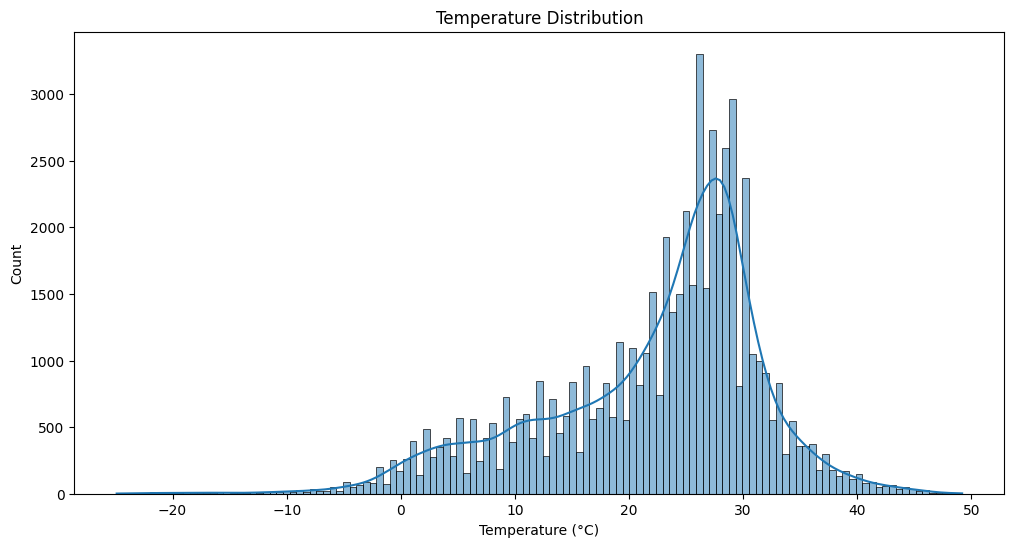

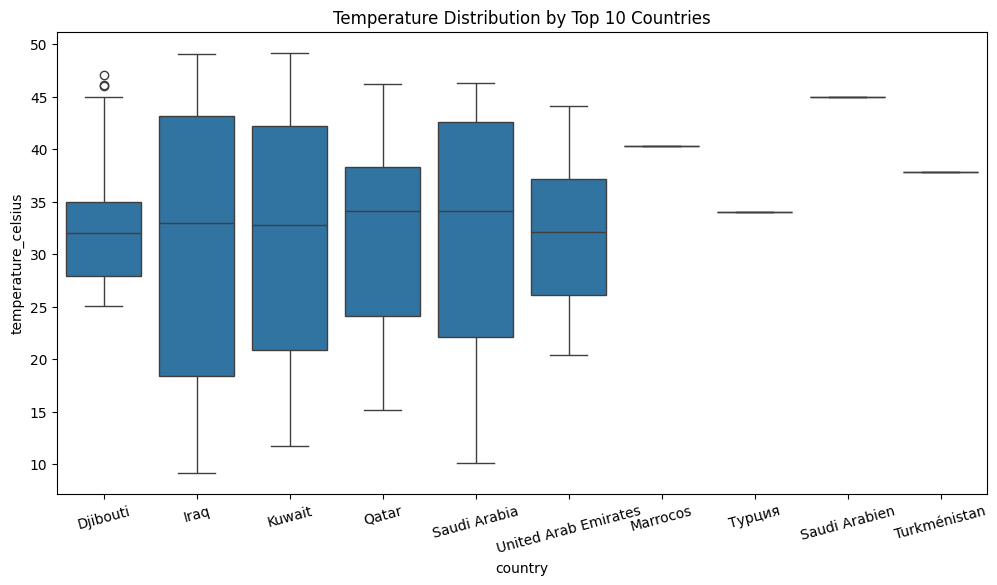

In [13]:
# Examine temperature distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['temperature_celsius'], kde=True)
plt.title('Temperature Distribution')
plt.xlabel('Temperature (°C)')
plt.savefig('temp_distribution.png')
plt.show()
plt.close()


# Temperature by country
top_countries = df.groupby('country')['temperature_celsius'].median().sort_values(ascending=False).head(10).index
filtered_df = df[df['country'].isin(top_countries)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='country', y='temperature_celsius', data=filtered_df)
plt.title('Temperature Distribution by Top 10 Countries')
plt.xticks(rotation=15)
plt.savefig('temp_by_country.png')
plt.show()
plt.close()


In [15]:
# Temperature correlation with other variables
numeric_df = df.select_dtypes(include=['float64', 'int64'])
temp_corr = numeric_df.corr()['temperature_celsius'].sort_values(ascending=False)
print("\nCorrelation with temperature:")
print(temp_corr)




Correlation with temperature:
temperature_celsius             1.000000
temperature_fahrenheit          0.999997
feels_like_celsius              0.981057
feels_like_fahrenheit           0.981051
uv_index                        0.534098
air_quality_Ozone               0.291487
visibility_miles                0.095602
longitude                       0.092179
visibility_km                   0.091392
gust_kph                        0.081585
gust_mph                        0.081564
wind_mph                        0.066740
wind_kph                        0.066668
air_quality_PM10                0.038037
precip_in                       0.020426
precip_mm                       0.020321
moon_illumination              -0.010863
wind_degree                    -0.047533
air_quality_gb-defra-index     -0.050863
air_quality_us-epa-index       -0.061309
air_quality_PM2.5              -0.064241
air_quality_Sulphur_dioxide    -0.082350
air_quality_Carbon_Monoxide    -0.085503
cloud                     

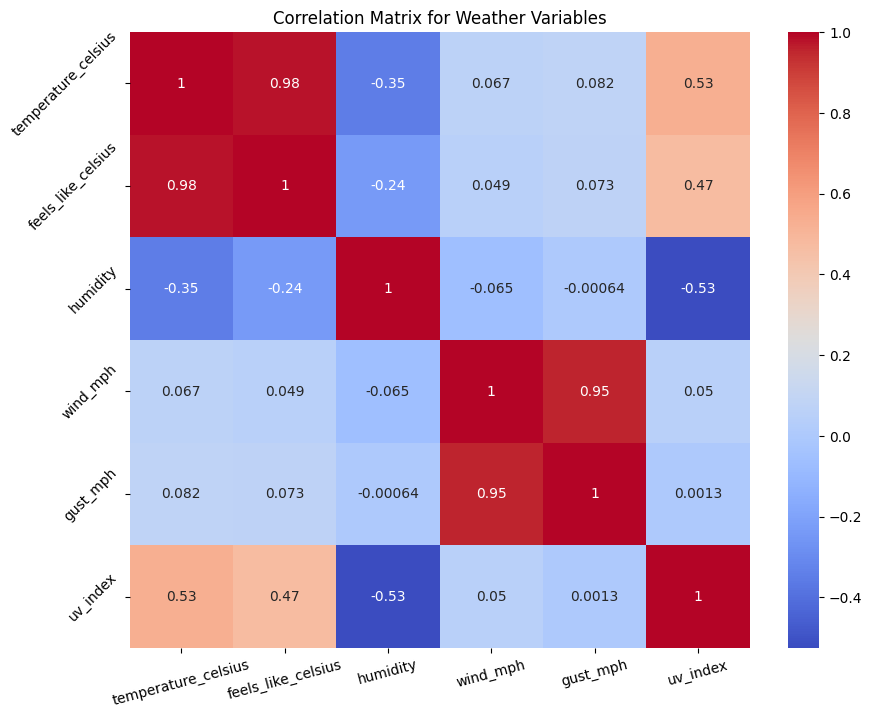

In [14]:
# Correlation heatmap for key variables
key_vars = ['temperature_celsius', 'feels_like_celsius', 'humidity', 'wind_mph', 'gust_mph','uv_index']
key_vars = [var for var in key_vars if var in df.columns]
plt.figure(figsize=(10, 8))
sns.heatmap(df[key_vars].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Weather Variables')
plt.xticks(rotation=15)
plt.yticks(rotation=45)

plt.savefig('correlation_matrix.png')
plt.show()
plt.close()

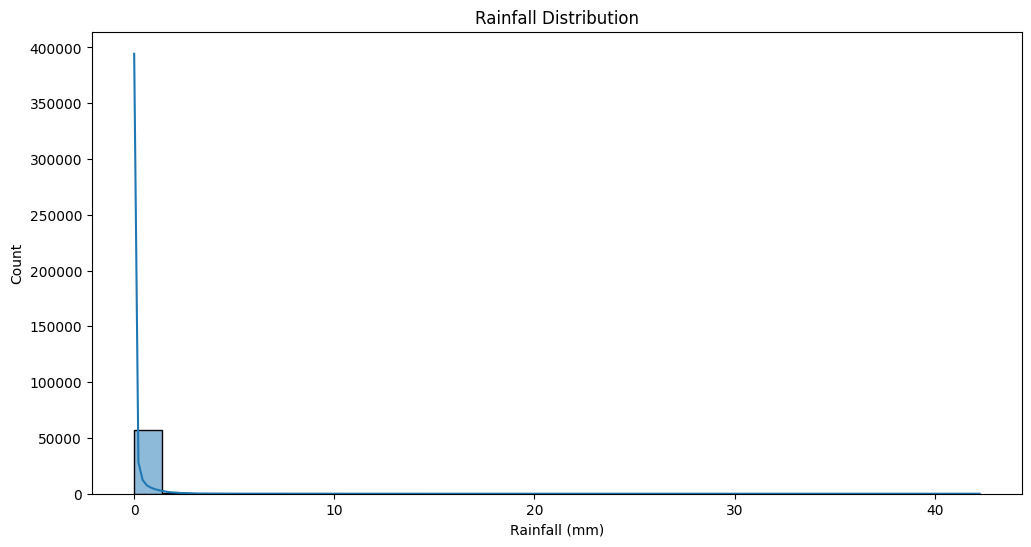

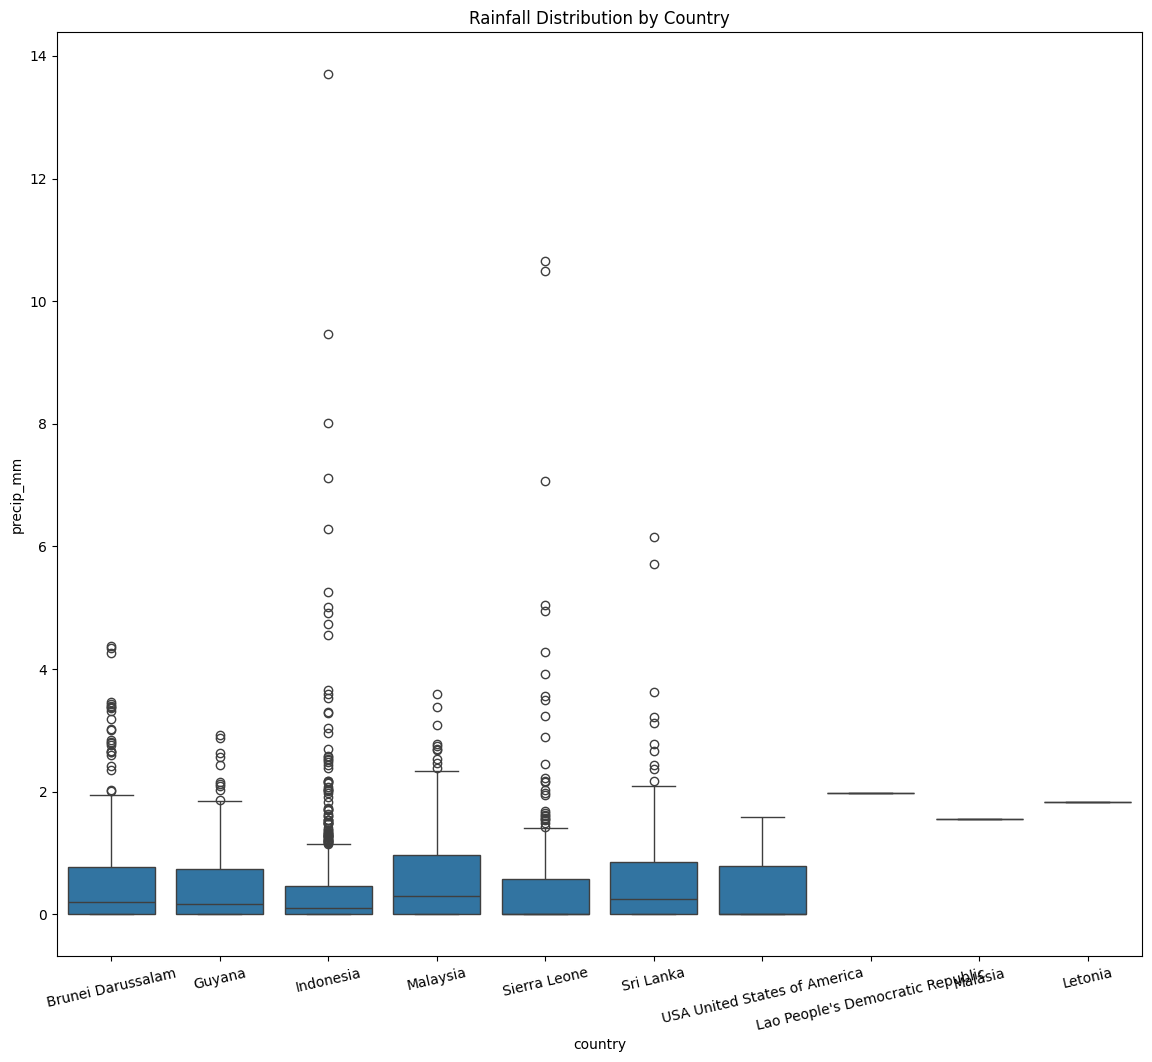

In [16]:
# Precipitation analysis
if 'precip_mm' in df.columns:
    # Distribution of rainfall
    plt.figure(figsize=(12, 6))
    sns.histplot(df['precip_mm'].dropna(), kde=True, bins=30)
    plt.title('Rainfall Distribution')
    plt.xlabel('Rainfall (mm)')
    plt.savefig('rainfall_distribution.png')
    plt.show()
    plt.close()

    # Rainfall by country
    top_countries = df.groupby('country')['precip_mm'].mean().sort_values(ascending=False).head(10).index
    filtered_df = df[df['country'].isin(top_countries)]
    plt.figure(figsize=(14, 12))
    sns.boxplot(x='country', y='precip_mm', data=filtered_df)
    plt.title('Rainfall Distribution by Country')
    plt.xticks(rotation=13)
    plt.savefig('rainfall_by_country.png')
    plt.show()
    plt.close()

# Time series analysis

In [17]:

# Group by date and calculate daily average temperature
df['last_updated'] = pd.to_datetime(df['last_updated'])

df['date'] = df['last_updated'].dt.date
daily_temp = df.groupby('date')['temperature_celsius'].mean().reset_index()
daily_temp['date'] = pd.to_datetime(daily_temp['date'])
daily_temp = daily_temp.sort_values('date')


# Prepare time series data for forecasting
# Set date as index
ts_data = daily_temp.set_index('date')

# Train-test split (80-20)
train_size = int(len(ts_data) * 0.8)
train, test = ts_data[:train_size], ts_data[train_size:]

print(f"Training data size: {train.shape}")
print(f"Testing data size: {test.shape}")


Training data size: (242, 1)
Testing data size: (61, 1)


In [18]:
# Prepare data for ML model
# Create lag features
def create_features(data, target_col, lag=14):
    df_features = data.copy()

    # Create lag features
    for i in range(1, lag+1):
        df_features[f'lag_{i}'] = df_features[target_col].shift(i)

    # Drop rows with NaN values that occur due to lag creation
    df_features = df_features.dropna()

    return df_features

# Define lag_days before using it
lag_days = 1 # Use 14 days of history

# Create features for training
train_features = create_features(train, 'temperature_celsius', lag=lag_days)

# Split features and target
X_train = train_features[[f'lag_{i}' for i in range(1, lag_days+1)]]
y_train = train_features['temperature_celsius']


# Time Series Forecasting

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from xgboost import XGBRegressor
# Linear regression as baseline
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# XGBoost
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Compare models on validation set
models = {
    'Linear Regression': lr_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'XGBoost': xgb_model,
}
test_features = create_features(test, 'temperature_celsius', lag=lag_days)

# Split into X_test and y_test
X_test = test_features[[f'lag_{i}' for i in range(1, lag_days+1)]]
y_test = test_features['temperature_celsius']


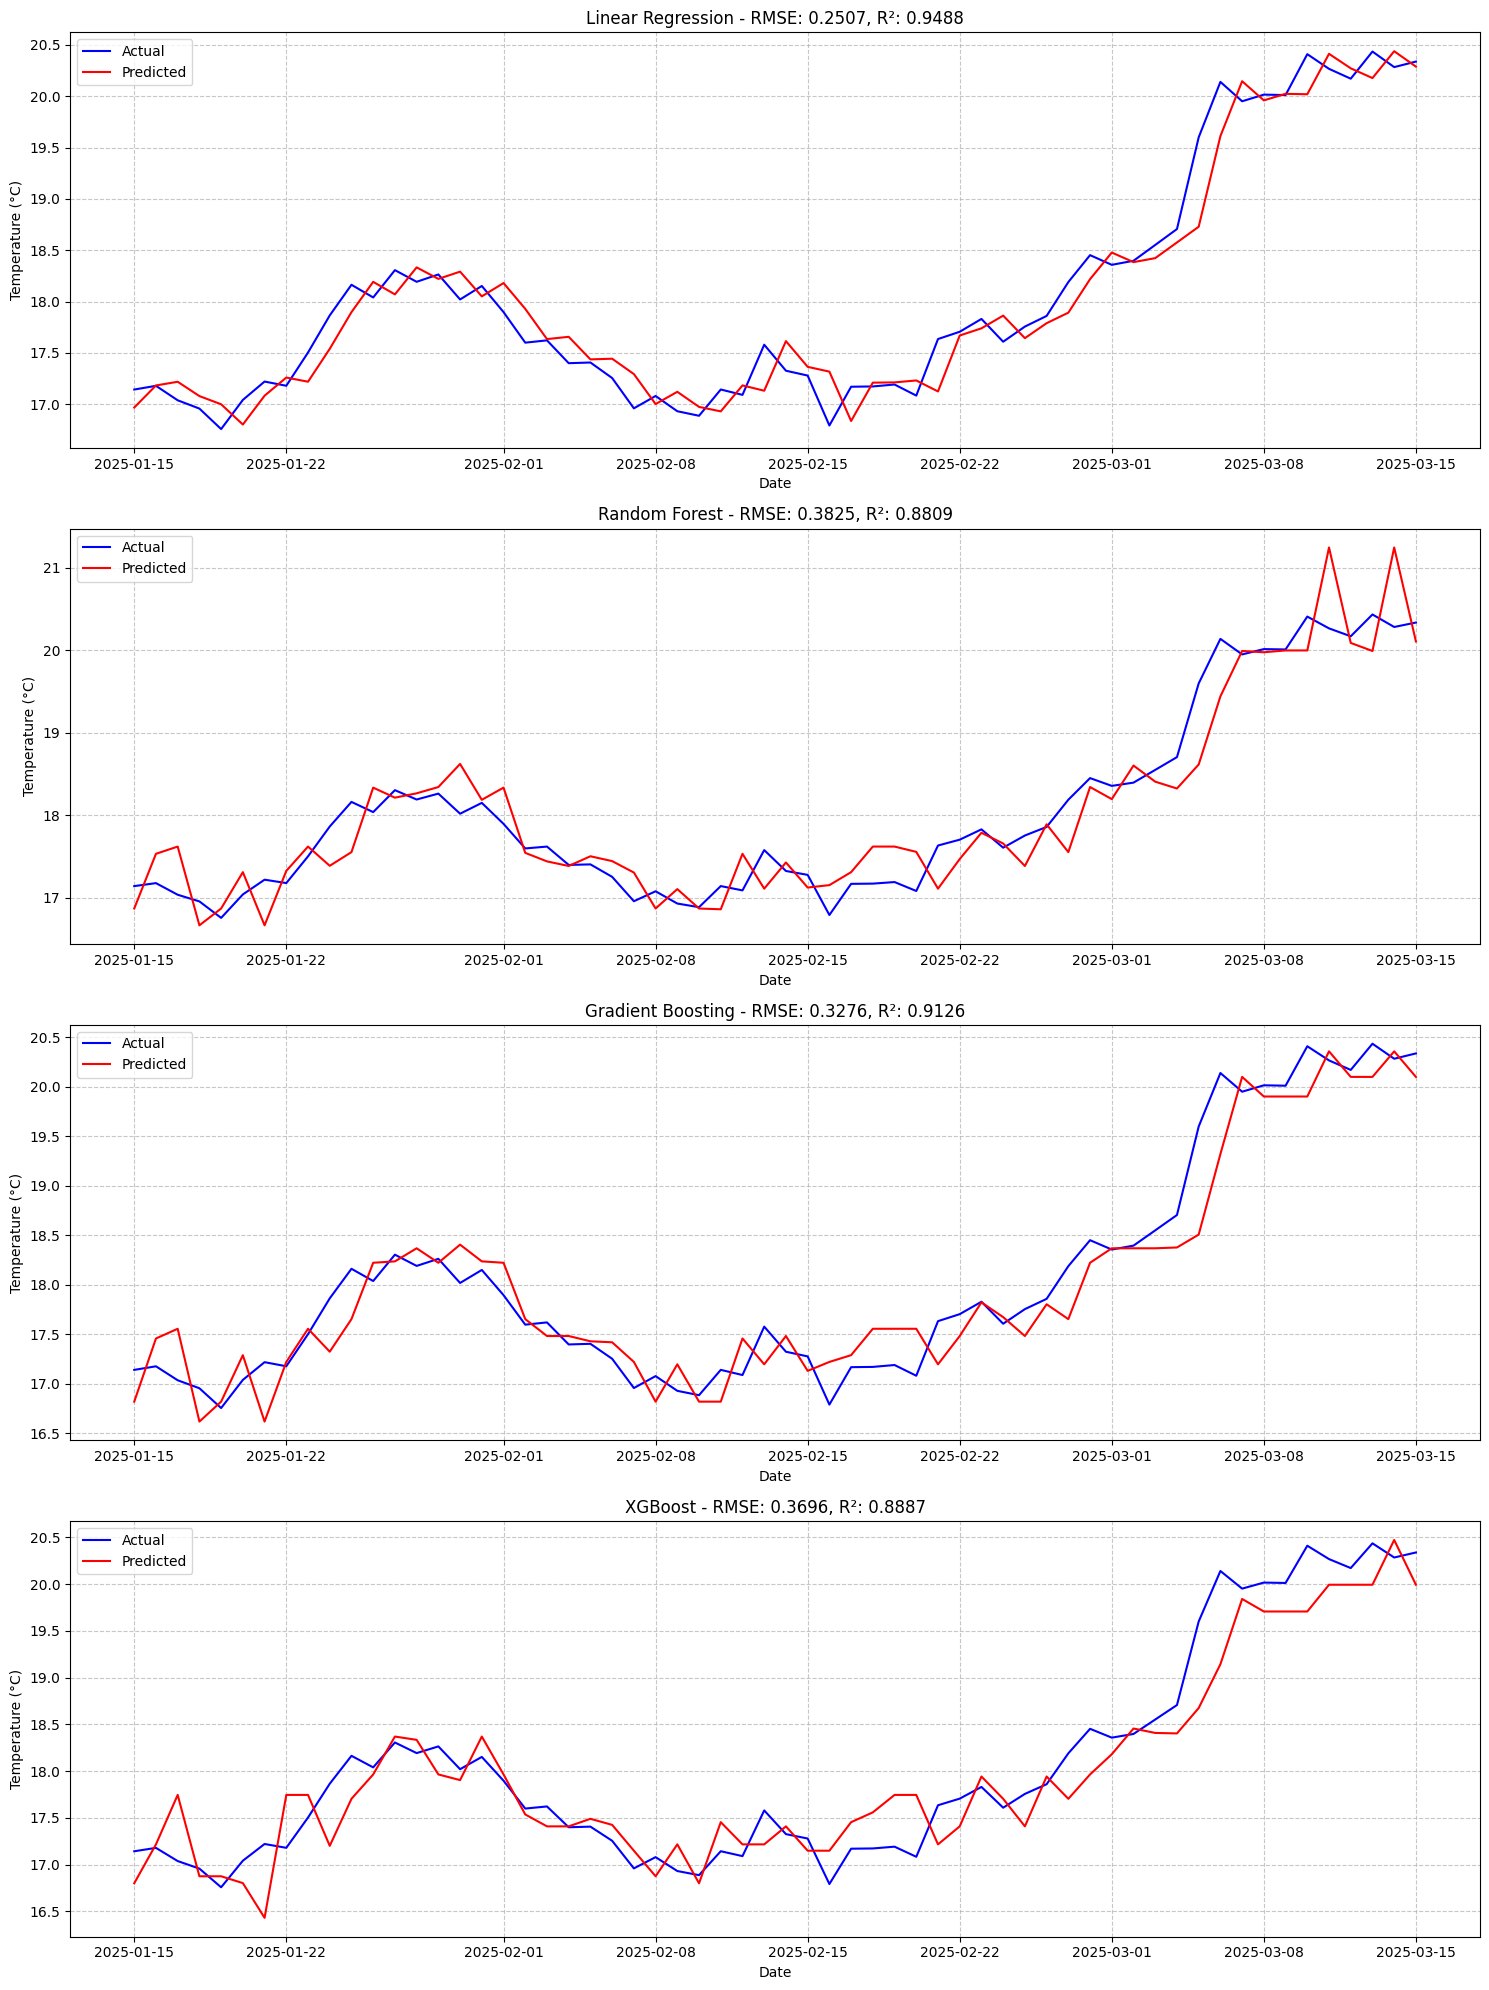

In [21]:
# Create subplots for each model
fig, axes = plt.subplots(len(models), 1, figsize=(15, 5*len(models)))

# Store performance metrics for comparison
performance = {}

# Create subplots for each model
for i, (name, model) in enumerate(models.items()):
    # Get predictions
    predictions = model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    performance[name] = {'RMSE': rmse, 'R²': r2}

    # Plot
    ax = axes[i]
    ax.plot(test_features.index, y_test, label='Actual', color='blue')
    ax.plot(test_features.index, predictions, label='Predicted', color='red')
    ax.set_title(f'{name} - RMSE: {rmse:.4f}, R²: {r2:.4f}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature (°C)')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()

plt.tight_layout()
plt.savefig('model_comparisons.png', dpi=300)
plt.show()
plt.close()

RMSE VALUES [0.25069592595534385, 0.3824688819546087, 0.32760917769311154, 0.36961088772985756]


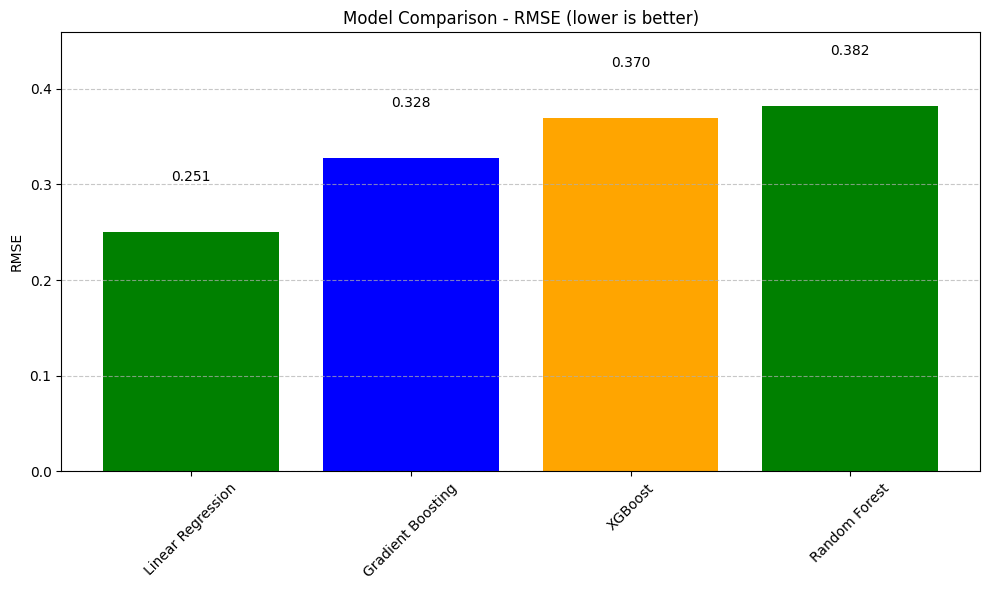

In [22]:
# Create a bar chart comparing RMSE values
plt.figure(figsize=(10, 6))
models_names = list(performance.keys())
rmse_values = [performance[model]['RMSE'] for model in models_names]
print("RMSE VALUES", rmse_values)

# Sort by performance (lower RMSE is better)
sorted_indices = np.argsort(rmse_values)
sorted_names = [models_names[i] for i in sorted_indices]
sorted_rmse = [rmse_values[i] for i in sorted_indices]

# Plot bars
bars = plt.bar(sorted_names, sorted_rmse, color=['green', 'blue', 'orange'])

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.3f}', ha='center', va='bottom')

plt.title('Model Comparison - RMSE (lower is better)')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.ylim(0, max(rmse_values) * 1.2)  # Give some headroom for the text
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('model_rmse_comparison.png', dpi=300)
plt.show()
plt.close()

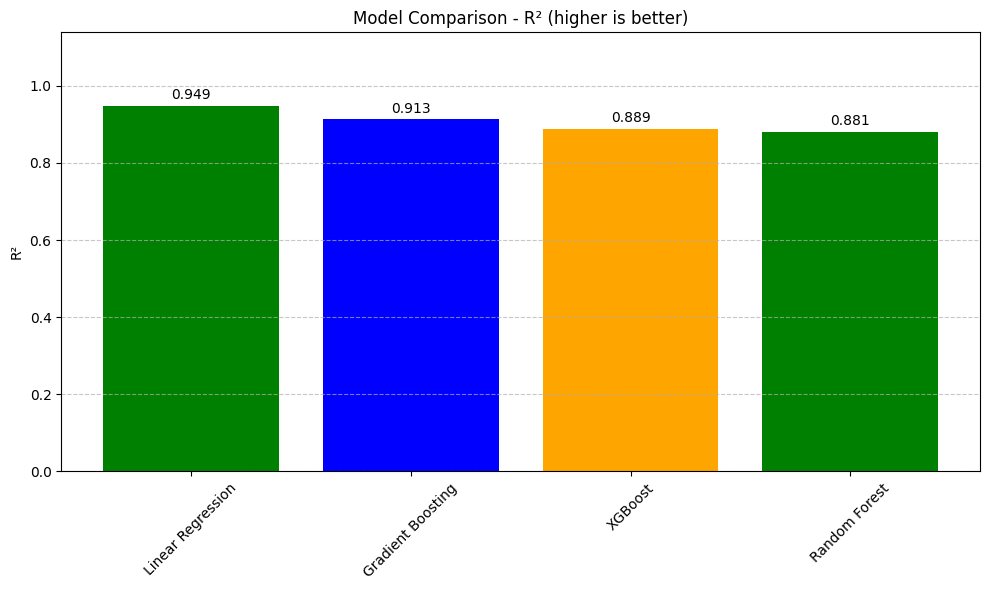

In [23]:
# Similar chart for R²
plt.figure(figsize=(10, 6))
r2_values = [performance[model]['R²'] for model in models_names]

# Sort by performance (higher R² is better)
sorted_indices = np.argsort(r2_values)[::-1]  # Reverse to get highest first
sorted_names = [models_names[i] for i in sorted_indices]
sorted_r2 = [r2_values[i] for i in sorted_indices]

# Plot bars
bars = plt.bar(sorted_names, sorted_r2, color=['green', 'blue', 'orange'])

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom')

plt.title('Model Comparison - R² (higher is better)')
plt.ylabel('R²')
plt.xticks(rotation=45)
plt.ylim(0, max(r2_values) * 1.2)  # Give some headroom for the text
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('model_r2_comparison.png', dpi=300)
plt.show()
plt.close()